In [14]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import json
import os
import joblib 

from sklearn.utils import class_weight # Added for class weights
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.python.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Ignore warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

print(f"TensorFlow Version: {tf.__version__}")

TensorFlow Version: 2.19.1


In [15]:
df = pd.read_csv("./Outputs/final.csv", header = 0)
print(f"Original data shape: {df.shape}")
#Define features
features_cols = ['EAR','MAR','PITCH','YAW','ROLL','D_SLUMP','R_TILT']
target_col = 'LABEL'
#Seperate X and y
X = df[features_cols]
y= df[target_col]

#Check for Class Imbalance
print("\nClass Distribution:")
print(y.value_counts().sort_index())
# Mapping 0=Awake, 1=Sleep, 2=Yawning

Original data shape: (11459, 11)

Class Distribution:
LABEL
0    4129
1    3709
2    3621
Name: count, dtype: int64


In [16]:
# from imblearn.over_sampling import SMOTE
# # 1. Setup SMOTE
# # sampling_strategy='auto' resamples all classes to match the majority class
# smote = SMOTE(sampling_strategy='auto', random_state=42)

# # 2. Resample X and y
# print(f"Original shape: {X_scaled.shape}")
# X_resampled, y_resampled = smote.fit_resample(X_scaled, y)

# print(f"New shape after SMOTE: {X_resampled.shape}")
# print(pd.Series(y_resampled).value_counts())

In [17]:
# Calculate weights based on your training data
y_integers = np.argmax(y_train, axis=1) # Convert back from one-hot for calculation

class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_integers),
    y=y_integers
)

# Convert to dictionary format required by Keras: {0: 1.0, 1: 5.2, ...}
class_weight_dict = dict(enumerate(class_weights))

print(f"Class Weights: {class_weight_dict}")

Class Weights: {0: 0.9251441753171857, 1: 1.0299178222907037, 2: 1.0547008547008547}


In [18]:
# 1. Split Data
# 70% Train, 15% Val, 15% Test
X_train_raw, X_temp, y_train_raw, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_val_raw, X_test_raw, y_val_raw, y_test_raw = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# 2. Scale Features (MinMax is standard for these geometric features)
scaler = MinMaxScaler()

# FIT only on Training Data
X_train = scaler.fit_transform(X_train_raw)

# TRANSFORM Validation and Test Data (Do NOT fit on them)
X_val = scaler.transform(X_val_raw)
X_test = scaler.transform(X_test_raw)

# 3. SAVE THE SCALER
joblib.dump(scaler, 'scaler.pkl')
print("\nScaler saved to 'scaler.pkl'. COPY THIS FILE to your demo folder.")

# 4. One-Hot Encode Targets
num_classes = 3 

y_train = to_categorical(y_train_raw, num_classes=num_classes)
y_val = to_categorical(y_val_raw, num_classes=num_classes)
y_test = to_categorical(y_test_raw, num_classes=num_classes)

print(f"\nTrain shape: {X_train.shape}")
print(f"Val shape:   {X_val.shape}")
print(f"Test shape:  {X_test.shape}")


Scaler saved to 'scaler.pkl'. COPY THIS FILE to your demo folder.

Train shape: (8021, 7)
Val shape:   (1719, 7)
Test shape:  (1719, 7)


PLOT EVALUATION GRAPH

In [19]:
def plot_history(history):
    # Get all metrics that are NOT 'loss' or 'val_loss'
    # logical logic: if key is 'accuracy', 'recall', etc.
    metrics = [k for k in history.history.keys() if k not in ['loss', 'val_loss', 'lr']]
    # Filter out validation keys (e.g., 'val_accuracy') to avoid duplicates in the list
    metrics = [m for m in metrics if not m.startswith('val_')]
    
    # Create subplots: 1 for Loss + 1 for each extra metric
    num_plots = 1 + len(metrics)
    fig, axes = plt.subplots(1, num_plots, figsize=(6 * num_plots, 4))
    
    # If there's only 1 plot (rare), wrap it in list so we can index it
    if num_plots == 1: axes = [axes]

    # --- Plot 1: LOSS ---
    axes[0].plot(history.history['loss'], label='Train Loss')
    if 'val_loss' in history.history:
        axes[0].plot(history.history['val_loss'], label='Val Loss')
    axes[0].set_title('Model Loss')
    axes[0].set_ylabel('Loss')
    axes[0].set_xlabel('Epoch')
    axes[0].legend()
    axes[0].grid(True)

    # --- Plot 2+: Other Metrics (Accuracy, Recall, etc.) ---
    for i, metric in enumerate(metrics):
        ax = axes[i+1]
        ax.plot(history.history[metric], label=f'Train {metric.capitalize()}')
        
        val_key = f'val_{metric}'
        if val_key in history.history:
            ax.plot(history.history[val_key], label=f'Val {metric.capitalize()}')
        
        ax.set_title(f'Model {metric.capitalize()}')
        ax.set_ylabel(metric.capitalize())
        ax.set_xlabel('Epoch')
        ax.legend()
        ax.grid(True)

    plt.tight_layout()
    plt.show()

DEFINE MODEL BEFORE TRAINING

In [20]:
n_feature = X_train.shape[1]

def train_model(x_train, y_train, x_valid, y_valid,
                num_nodes, dropout_prob, lr, batch_size, epochs):
    # Build model (Classification architecture for your problem)
    # Note: Modified to use 'softmax' output for Classification as per your earlier cells
    nn_model = Sequential([
        Dense(num_nodes, activation='relu', input_shape=(n_feature,)),
        Dropout(dropout_prob),
        Dense(num_nodes, activation='relu'),
        Dropout(dropout_prob),
        Dense(num_classes, activation='softmax') # Use softmax for multi-class classification
    ])

    # Compile
    nn_model.compile(
        optimizer=Adam(learning_rate=lr),
        loss='categorical_crossentropy', # Use Cat Crossentropy for Classification
        metrics=['accuracy', tf.keras.metrics.Recall()]             # Monitor Accuracy
    )
    
    # Early Stopping
    early_stop = EarlyStopping(
        monitor='val_loss',       # what metric to watch
        patience=10,              # how many epochs to wait (reduced to 10 for faster iterating)
        restore_best_weights=True # revert to best weights
    )

    # Train
    history = nn_model.fit(
        x_train, y_train,
        validation_data=(x_valid, y_valid),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[early_stop],
        class_weight=class_weight_dict, # <--- ADD THIS LINE
        verbose=0 # Silent training
    )
    # Extract final metrics
    final_train_loss = history.history['loss'][-1]
    final_val_loss = history.history['val_loss'][-1]
    final_train_acc = history.history['accuracy'][-1]
    final_val_acc = history.history['val_accuracy'][-1]

    print(f"   -> Final Train Loss: {final_train_loss:.4f}, Acc: {final_train_acc:.4f}")
    print(f"   -> Final Val Loss:   {final_val_loss:.4f}, Acc: {final_val_acc:.4f}")

    return nn_model, history

print("Training functions defined.")

Training functions defined.


INITIATE TRAINING

Starting Grid Search on 72 combinations...

[1/72] Testing: Nodes=16 | Dropout=0 | LR=0.01 | Batch=16
   -> Final Train Loss: 0.1664, Acc: 0.9413
   -> Final Val Loss:   0.1604, Acc: 0.9494


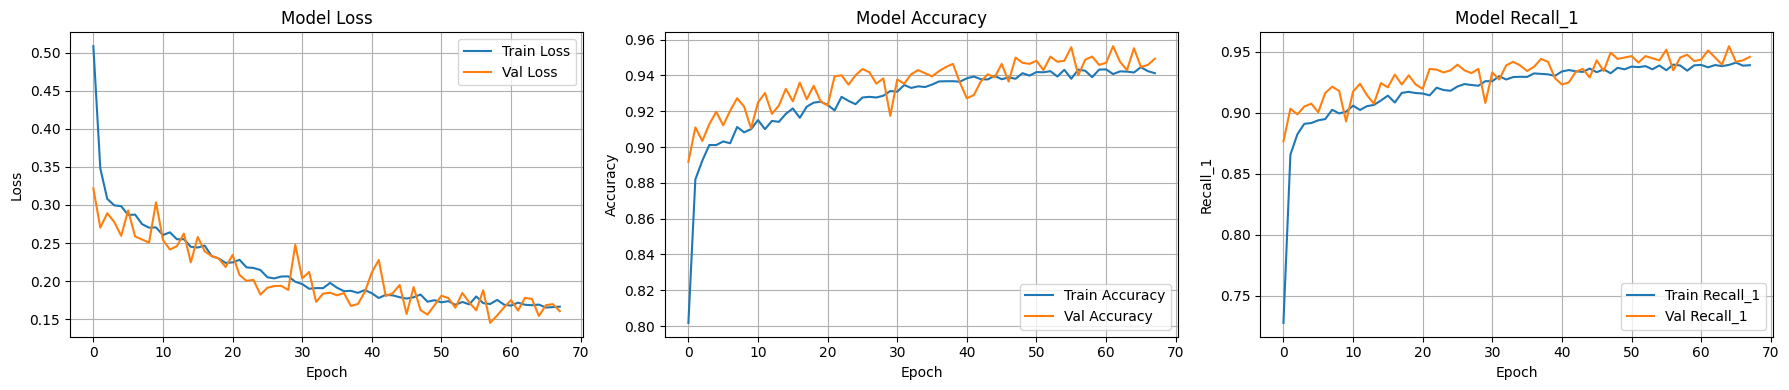

Validation Loss = 0.1450
least val_loss = 0.1450
   *** NEW BEST MODEL FOUND *** (Val Loss: 0.1450)


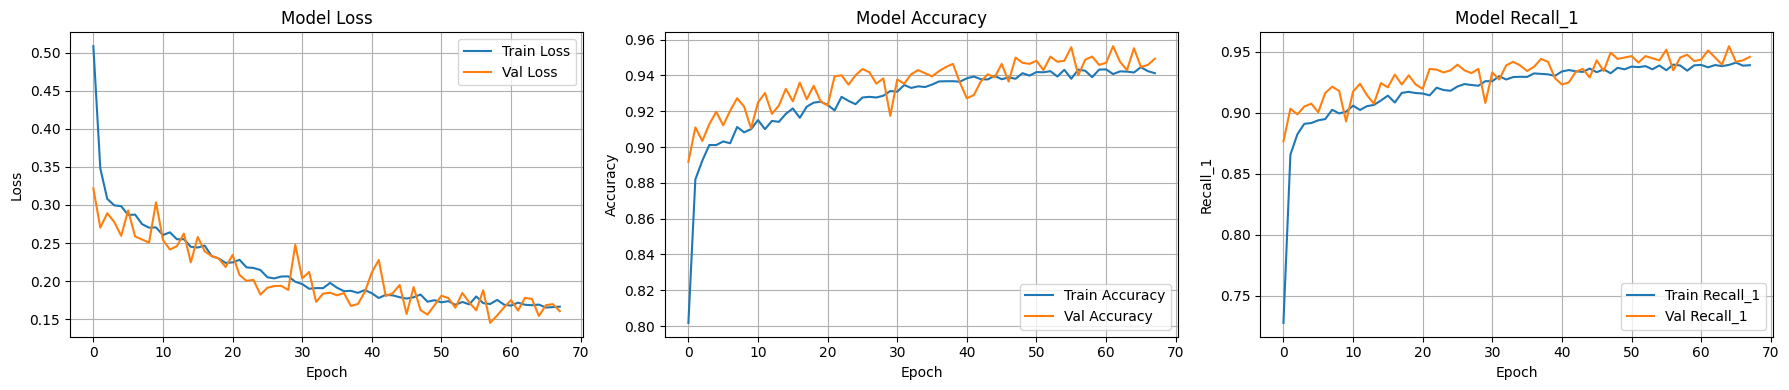


[2/72] Testing: Nodes=16 | Dropout=0 | LR=0.01 | Batch=32
   -> Final Train Loss: 0.2019, Acc: 0.9323
   -> Final Val Loss:   0.2281, Acc: 0.9348


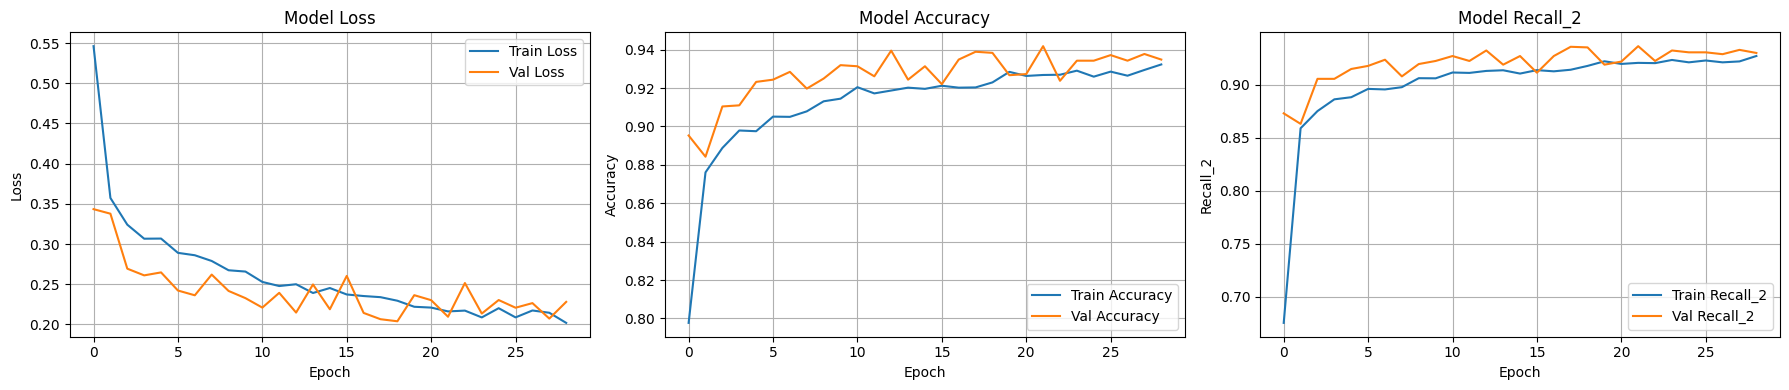

Validation Loss = 0.2039

[3/72] Testing: Nodes=16 | Dropout=0 | LR=0.01 | Batch=64
   -> Final Train Loss: 0.1825, Acc: 0.9385
   -> Final Val Loss:   0.1687, Acc: 0.9383


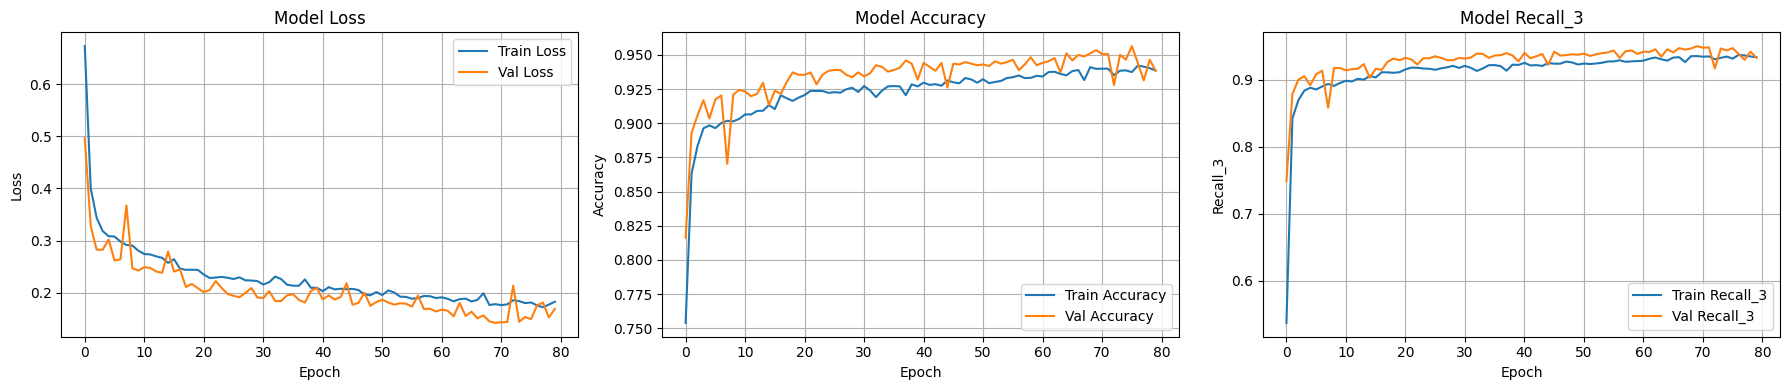

Validation Loss = 0.1420
least val_loss = 0.1420
   *** NEW BEST MODEL FOUND *** (Val Loss: 0.1420)


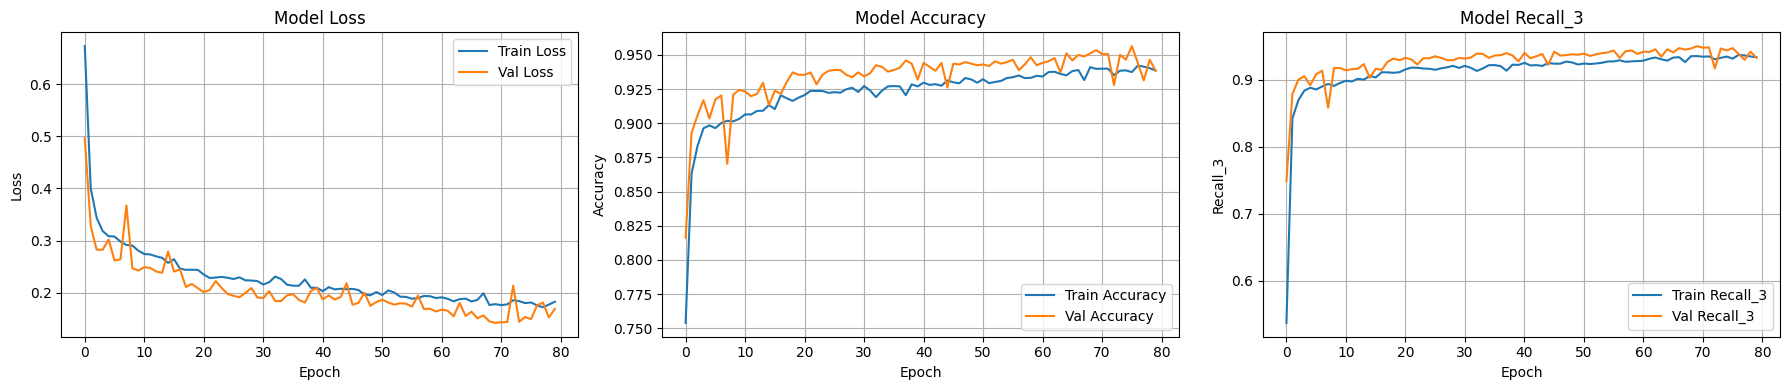


[4/72] Testing: Nodes=16 | Dropout=0 | LR=0.005 | Batch=16
   -> Final Train Loss: 0.1977, Acc: 0.9342
   -> Final Val Loss:   0.1878, Acc: 0.9424


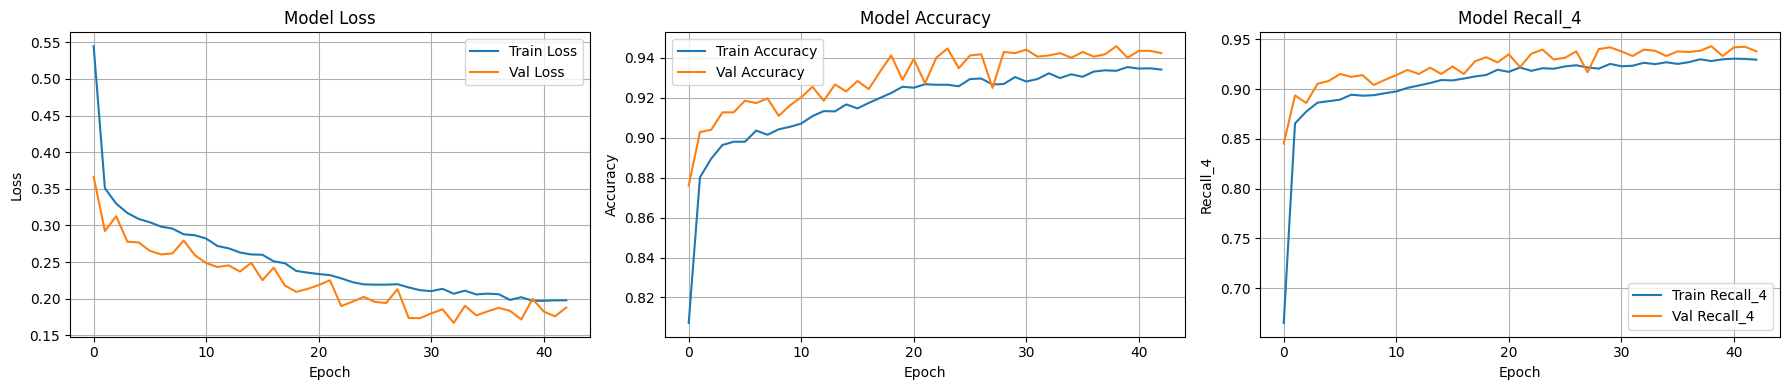

Validation Loss = 0.1669

[5/72] Testing: Nodes=16 | Dropout=0 | LR=0.005 | Batch=32
   -> Final Train Loss: 0.1948, Acc: 0.9344
   -> Final Val Loss:   0.1934, Acc: 0.9424


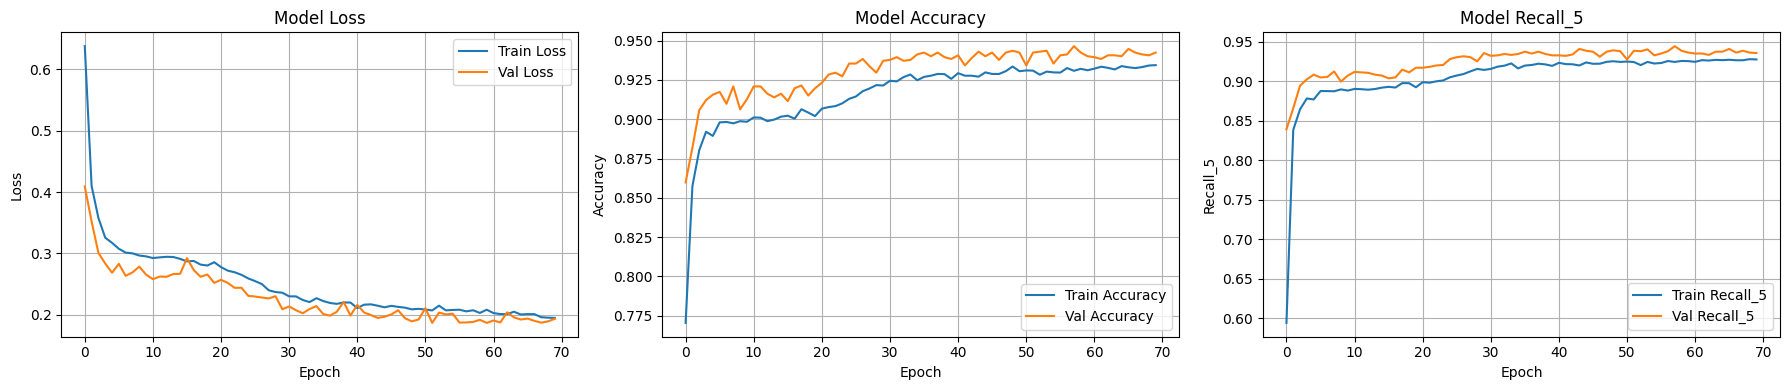

Validation Loss = 0.1867

[6/72] Testing: Nodes=16 | Dropout=0 | LR=0.005 | Batch=64
   -> Final Train Loss: 0.2623, Acc: 0.9142
   -> Final Val Loss:   0.2437, Acc: 0.9186


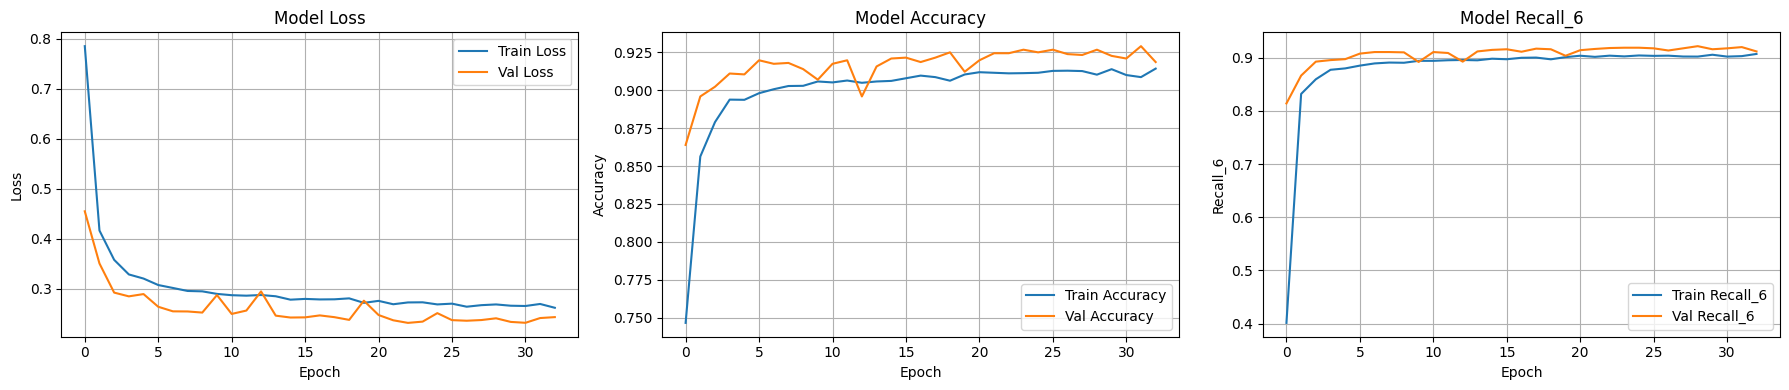

Validation Loss = 0.2322

[7/72] Testing: Nodes=16 | Dropout=0 | LR=0.001 | Batch=16
   -> Final Train Loss: 0.2417, Acc: 0.9232
   -> Final Val Loss:   0.2403, Acc: 0.9226


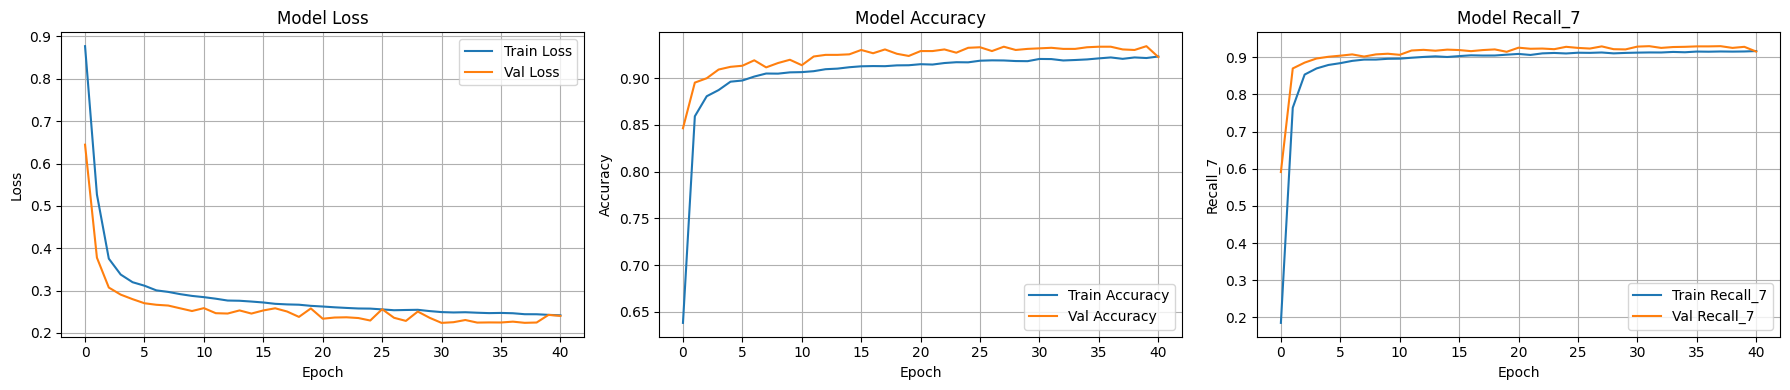

Validation Loss = 0.2238

[8/72] Testing: Nodes=16 | Dropout=0 | LR=0.001 | Batch=32
   -> Final Train Loss: 0.2104, Acc: 0.9299
   -> Final Val Loss:   0.1932, Acc: 0.9436


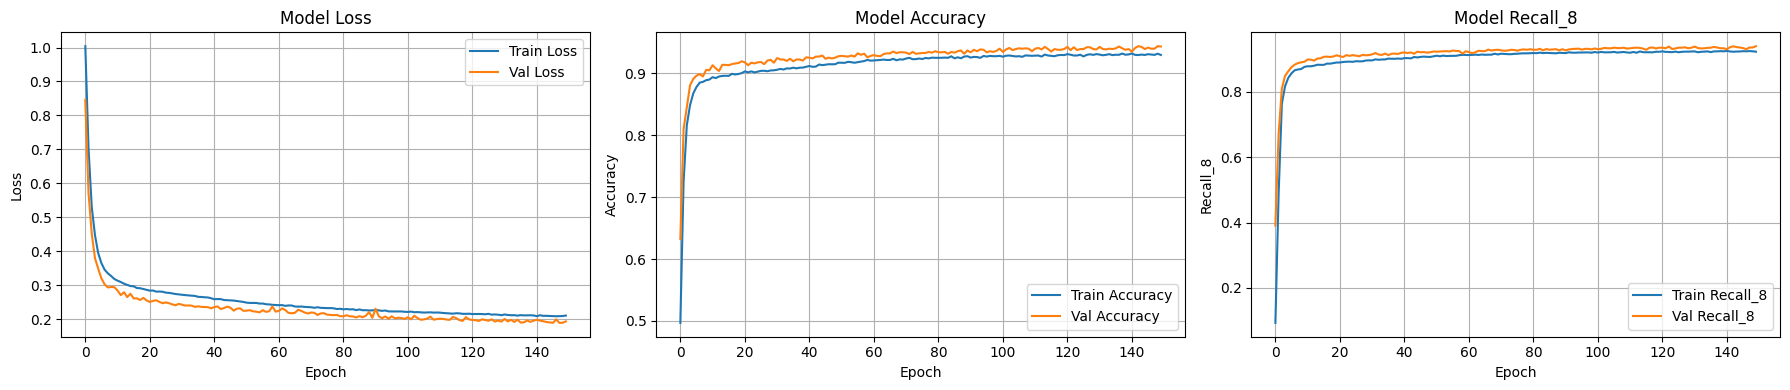

Validation Loss = 0.1932

[9/72] Testing: Nodes=16 | Dropout=0 | LR=0.001 | Batch=64
   -> Final Train Loss: 0.2243, Acc: 0.9297
   -> Final Val Loss:   0.2108, Acc: 0.9360


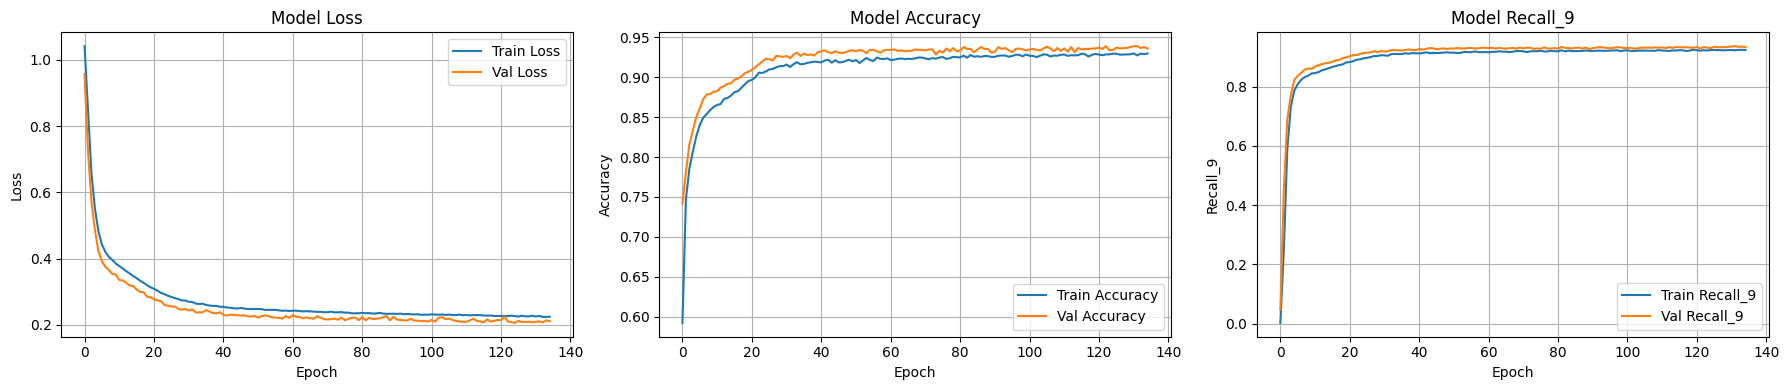

Validation Loss = 0.2056

[10/72] Testing: Nodes=16 | Dropout=0.2 | LR=0.01 | Batch=16
   -> Final Train Loss: 0.3467, Acc: 0.8872
   -> Final Val Loss:   0.3049, Acc: 0.8970


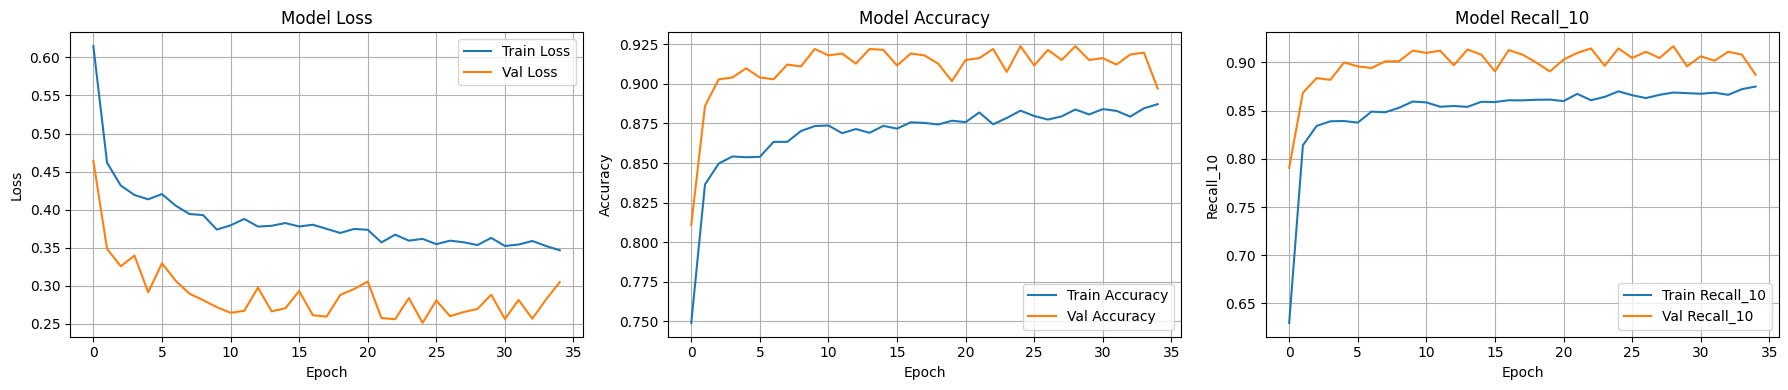

Validation Loss = 0.2513

[11/72] Testing: Nodes=16 | Dropout=0.2 | LR=0.01 | Batch=32
   -> Final Train Loss: 0.3637, Acc: 0.8834
   -> Final Val Loss:   0.2549, Acc: 0.9226


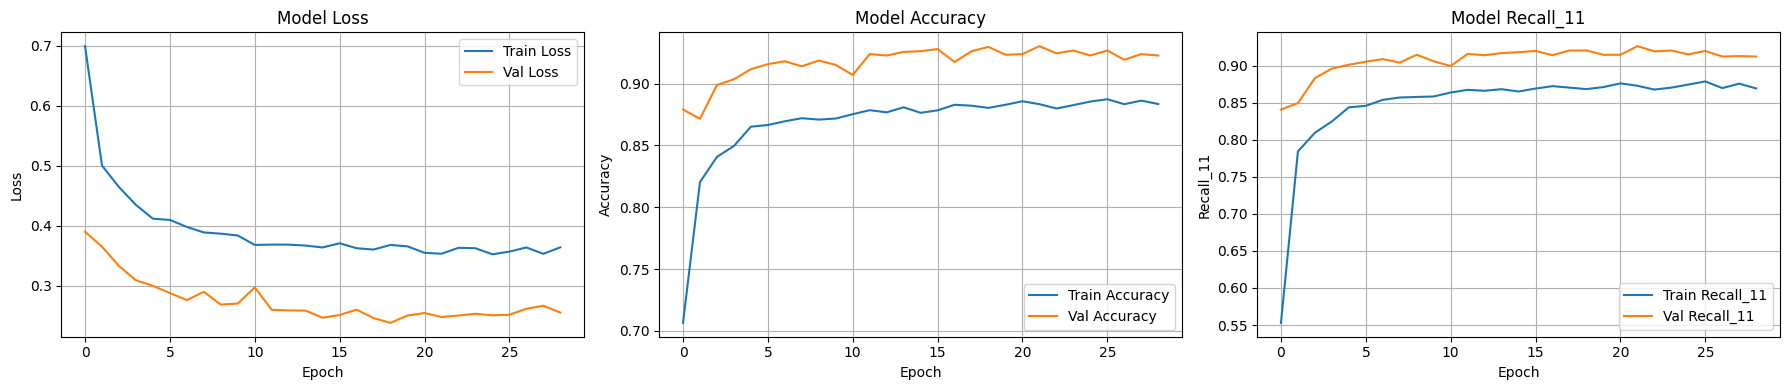

Validation Loss = 0.2376

[12/72] Testing: Nodes=16 | Dropout=0.2 | LR=0.01 | Batch=64
   -> Final Train Loss: 0.2889, Acc: 0.9043
   -> Final Val Loss:   0.2193, Acc: 0.9337


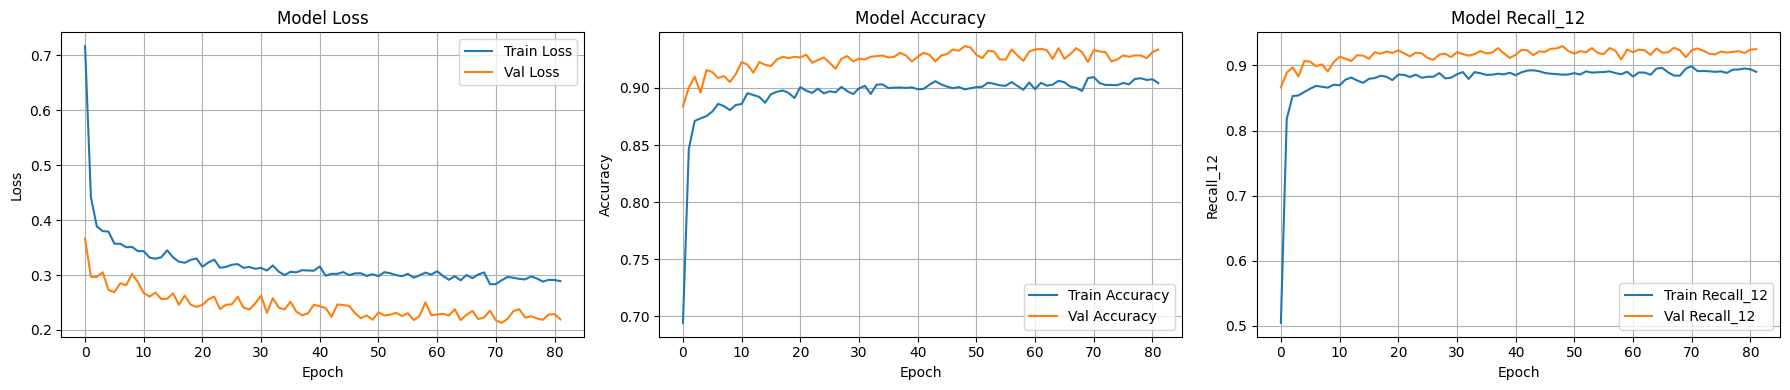

Validation Loss = 0.2129

[13/72] Testing: Nodes=16 | Dropout=0.2 | LR=0.005 | Batch=16
   -> Final Train Loss: 0.2937, Acc: 0.9015
   -> Final Val Loss:   0.2256, Acc: 0.9290


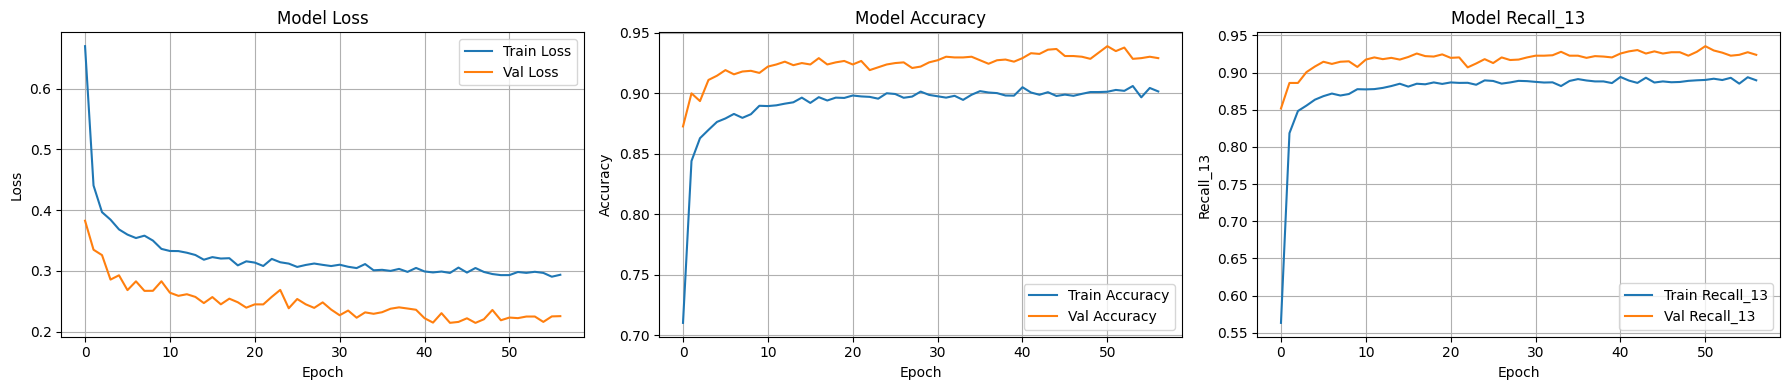

Validation Loss = 0.2146

[14/72] Testing: Nodes=16 | Dropout=0.2 | LR=0.005 | Batch=32
   -> Final Train Loss: 0.3057, Acc: 0.9003
   -> Final Val Loss:   0.2374, Acc: 0.9290


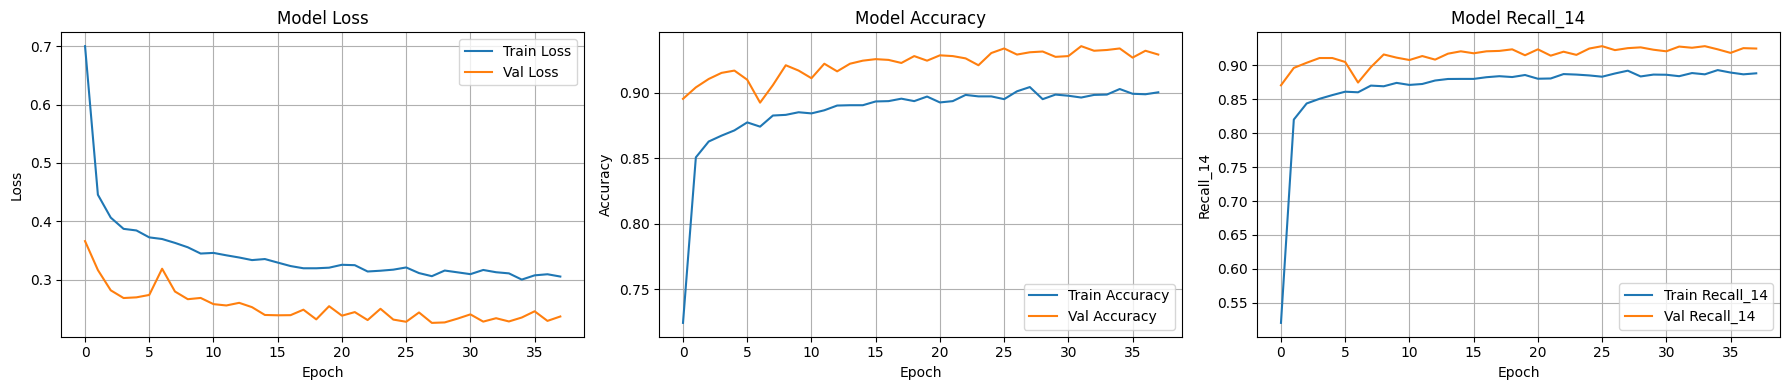

Validation Loss = 0.2265

[15/72] Testing: Nodes=16 | Dropout=0.2 | LR=0.005 | Batch=64
   -> Final Train Loss: 0.3461, Acc: 0.8829
   -> Final Val Loss:   0.2534, Acc: 0.9244


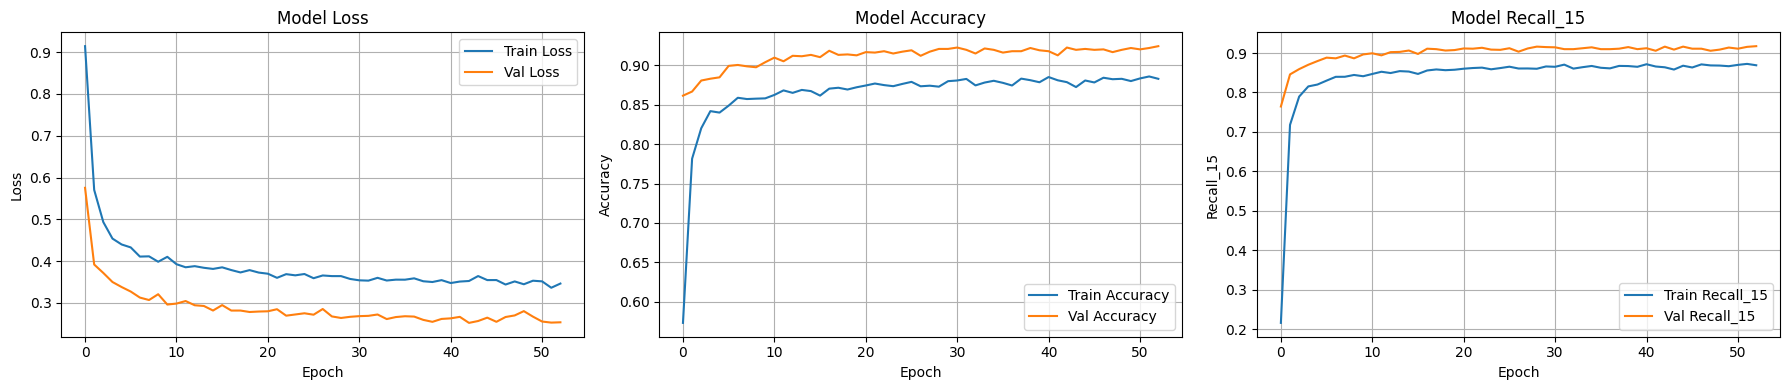

Validation Loss = 0.2520

[16/72] Testing: Nodes=16 | Dropout=0.2 | LR=0.001 | Batch=16
   -> Final Train Loss: 0.3460, Acc: 0.8863
   -> Final Val Loss:   0.2553, Acc: 0.9197


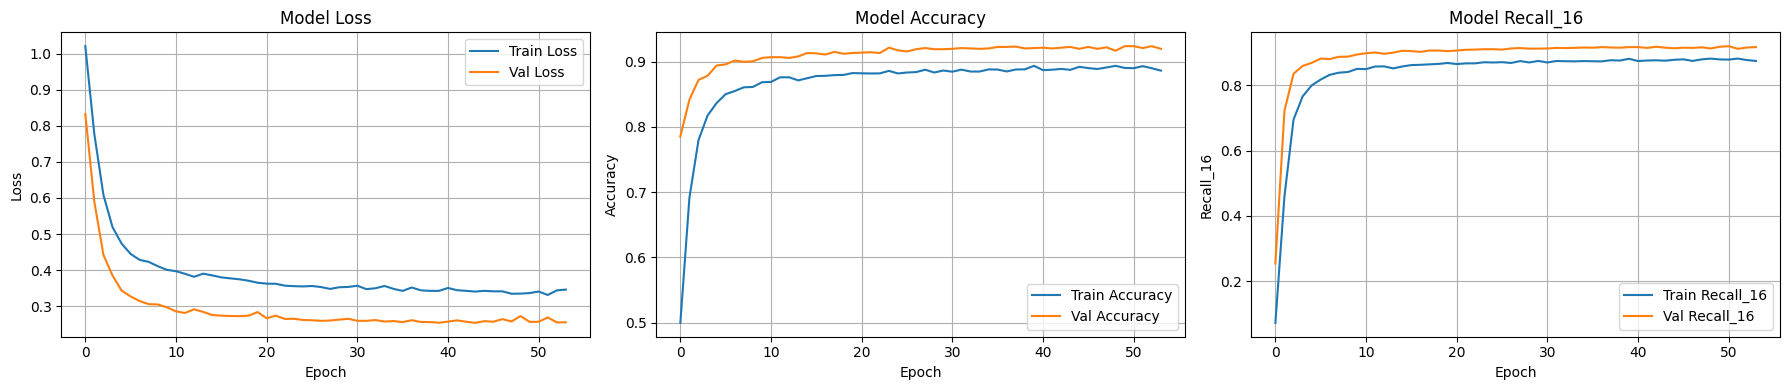

Validation Loss = 0.2537

[17/72] Testing: Nodes=16 | Dropout=0.2 | LR=0.001 | Batch=32
   -> Final Train Loss: 0.3201, Acc: 0.8970
   -> Final Val Loss:   0.2650, Acc: 0.9215


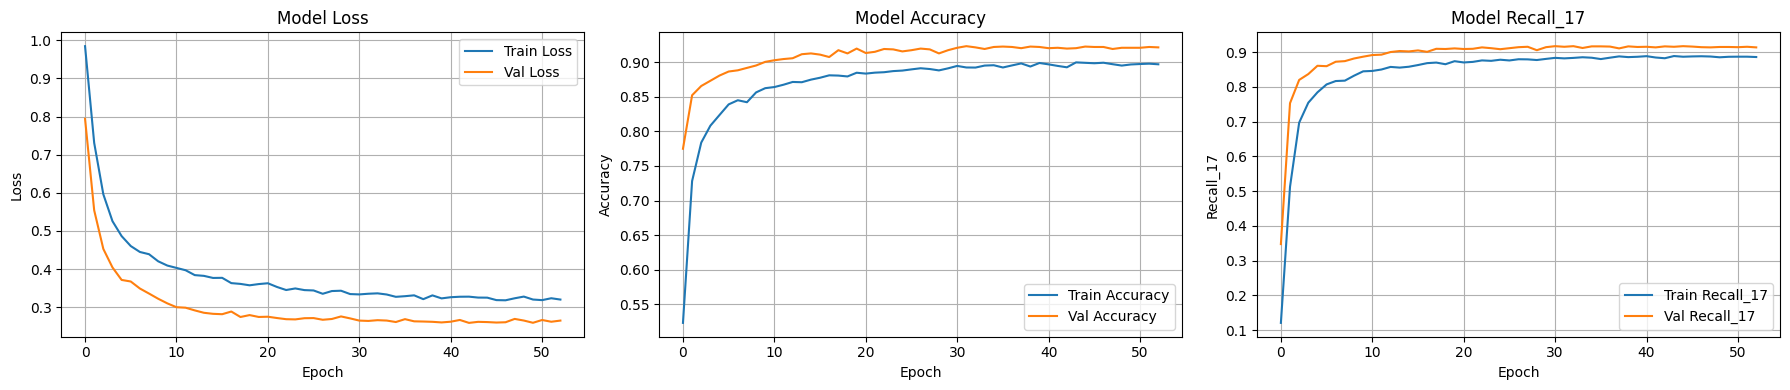

Validation Loss = 0.2590

[18/72] Testing: Nodes=16 | Dropout=0.2 | LR=0.001 | Batch=64
   -> Final Train Loss: 0.2917, Acc: 0.9060
   -> Final Val Loss:   0.2282, Acc: 0.9296


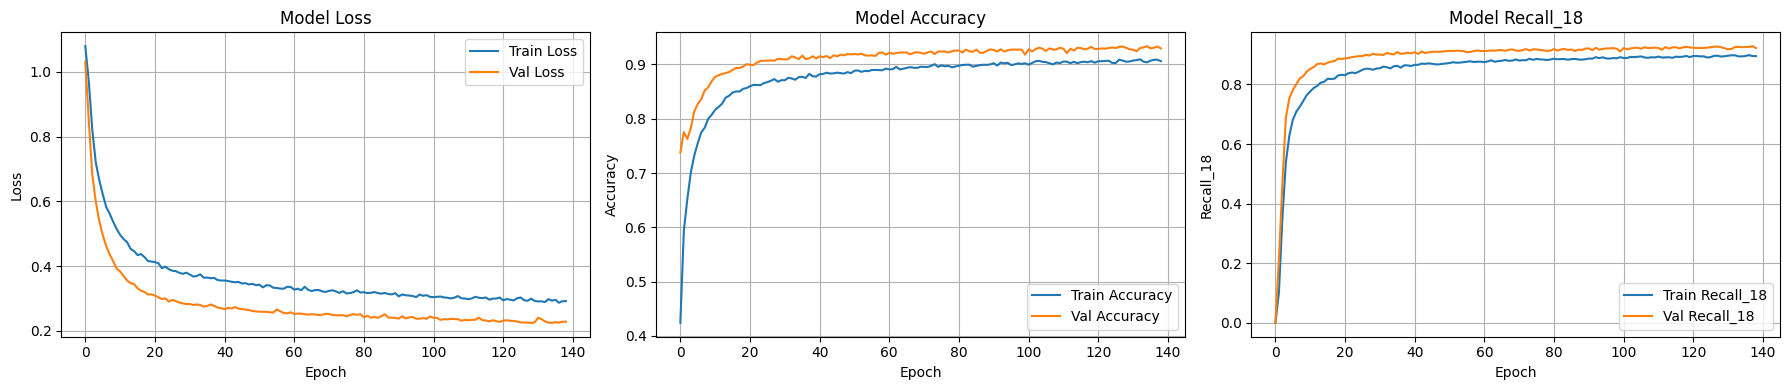

Validation Loss = 0.2244

[19/72] Testing: Nodes=32 | Dropout=0 | LR=0.01 | Batch=16
   -> Final Train Loss: 0.1192, Acc: 0.9581
   -> Final Val Loss:   0.1575, Acc: 0.9465


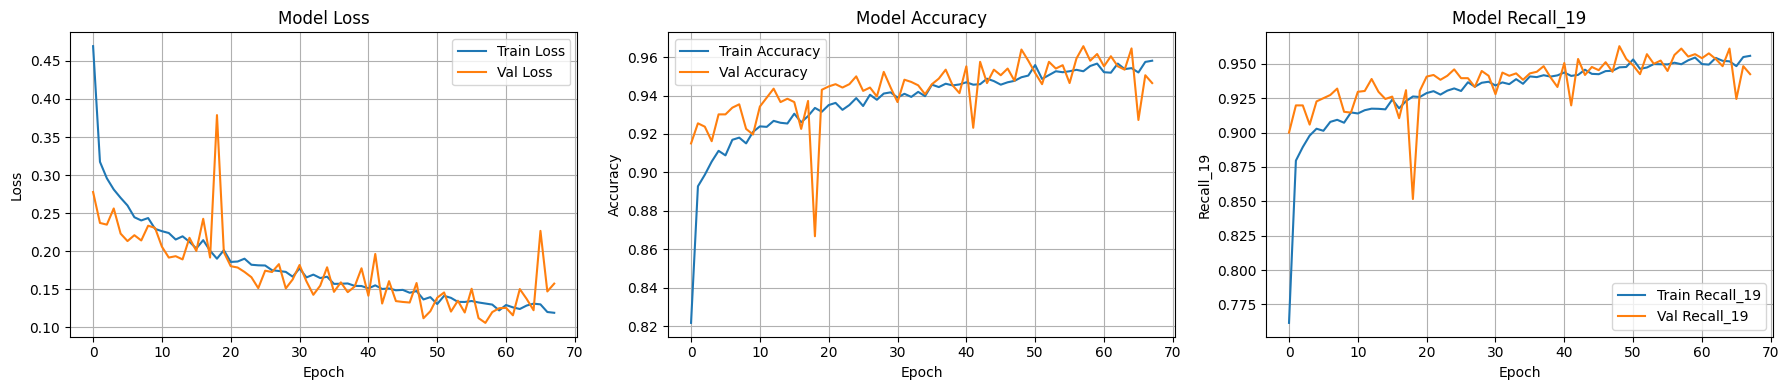

Validation Loss = 0.1059
least val_loss = 0.1059
   *** NEW BEST MODEL FOUND *** (Val Loss: 0.1059)


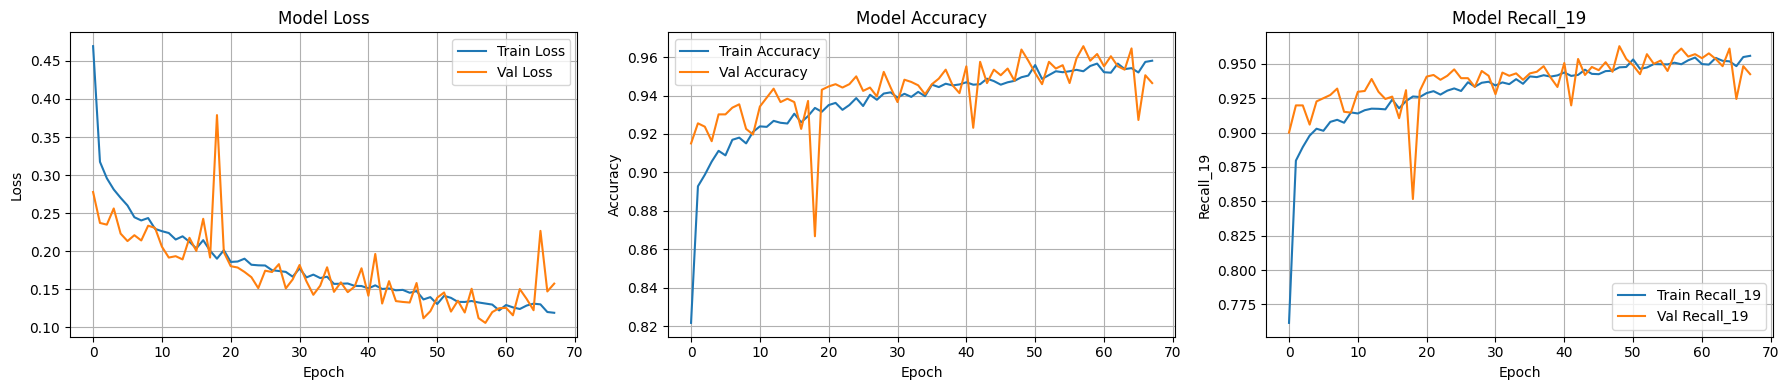


[20/72] Testing: Nodes=32 | Dropout=0 | LR=0.01 | Batch=32
   -> Final Train Loss: 0.1556, Acc: 0.9463
   -> Final Val Loss:   0.1811, Acc: 0.9471


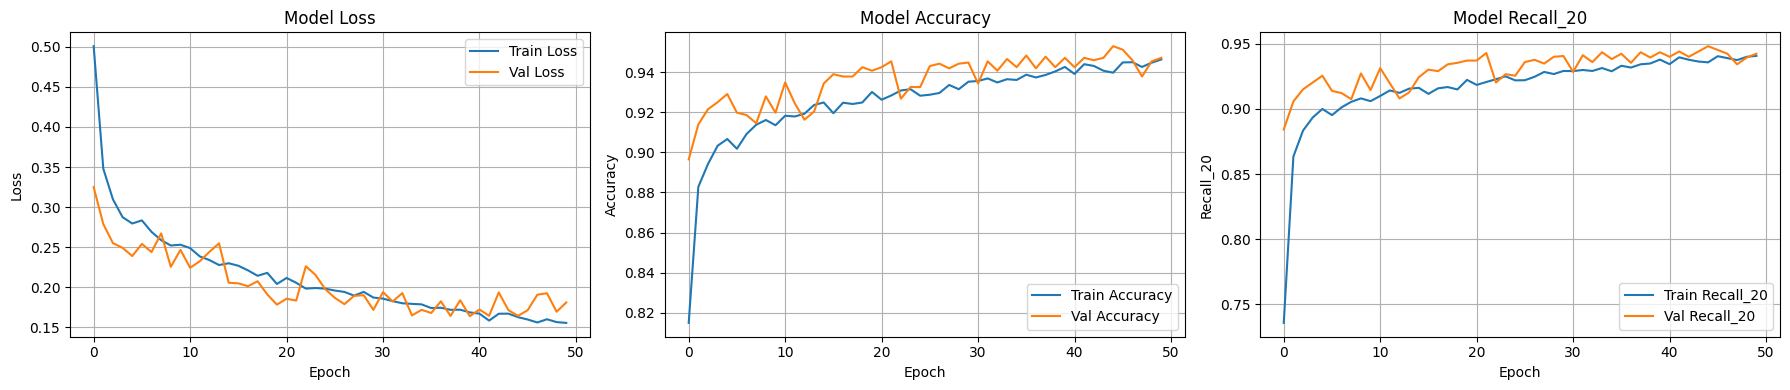

Validation Loss = 0.1640

[21/72] Testing: Nodes=32 | Dropout=0 | LR=0.01 | Batch=64
   -> Final Train Loss: 0.1265, Acc: 0.9542
   -> Final Val Loss:   0.1562, Acc: 0.9529


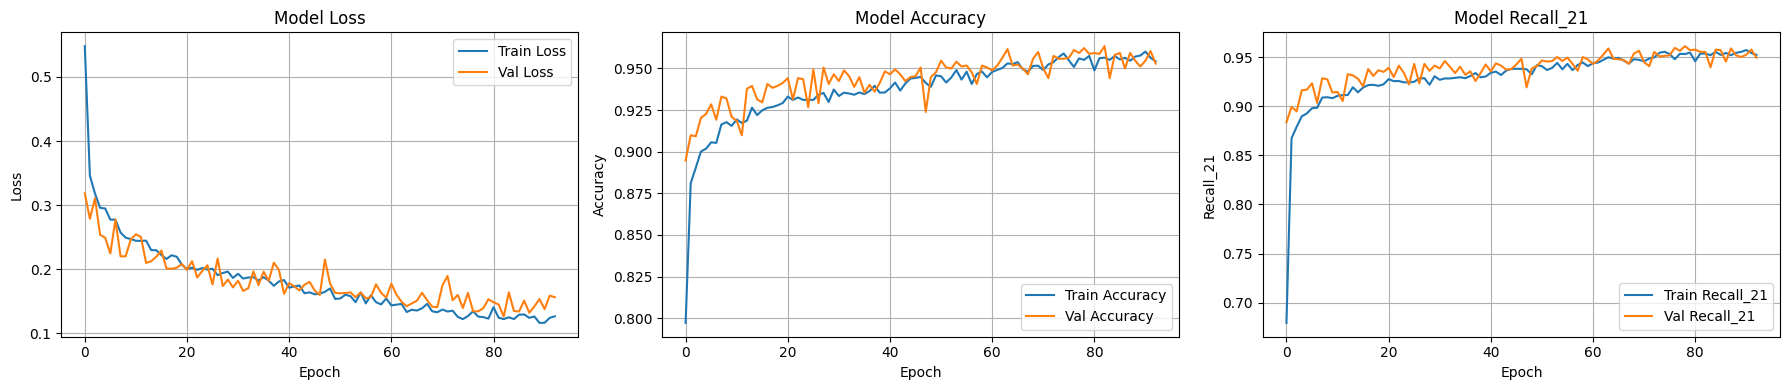

Validation Loss = 0.1261

[22/72] Testing: Nodes=32 | Dropout=0 | LR=0.005 | Batch=16
   -> Final Train Loss: 0.1102, Acc: 0.9626
   -> Final Val Loss:   0.1424, Acc: 0.9645


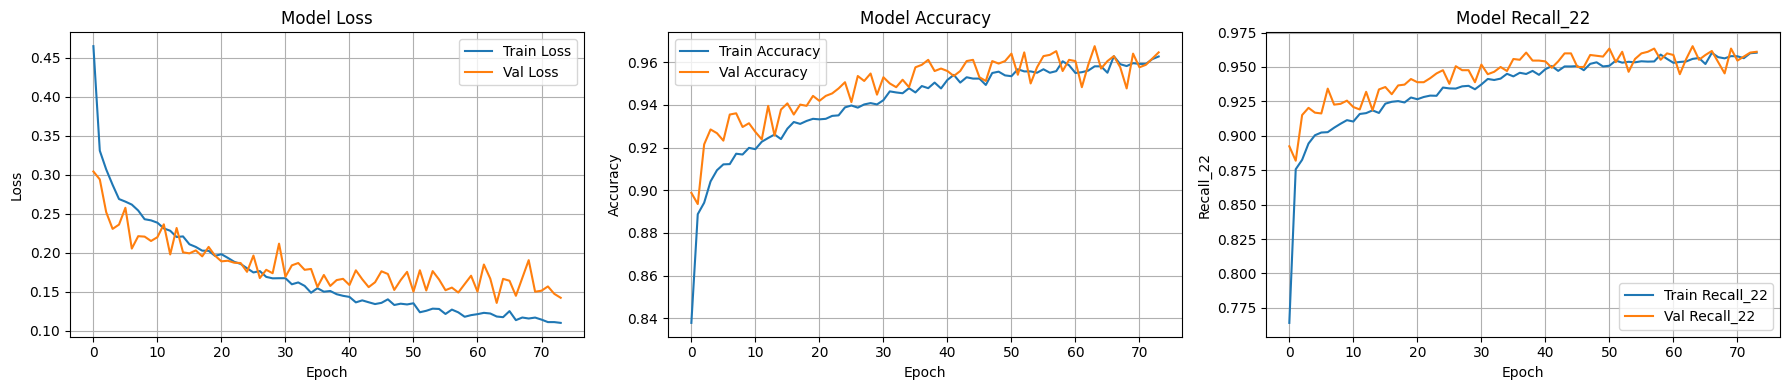

Validation Loss = 0.1358

[23/72] Testing: Nodes=32 | Dropout=0 | LR=0.005 | Batch=32
   -> Final Train Loss: 0.1174, Acc: 0.9597
   -> Final Val Loss:   0.1572, Acc: 0.9535


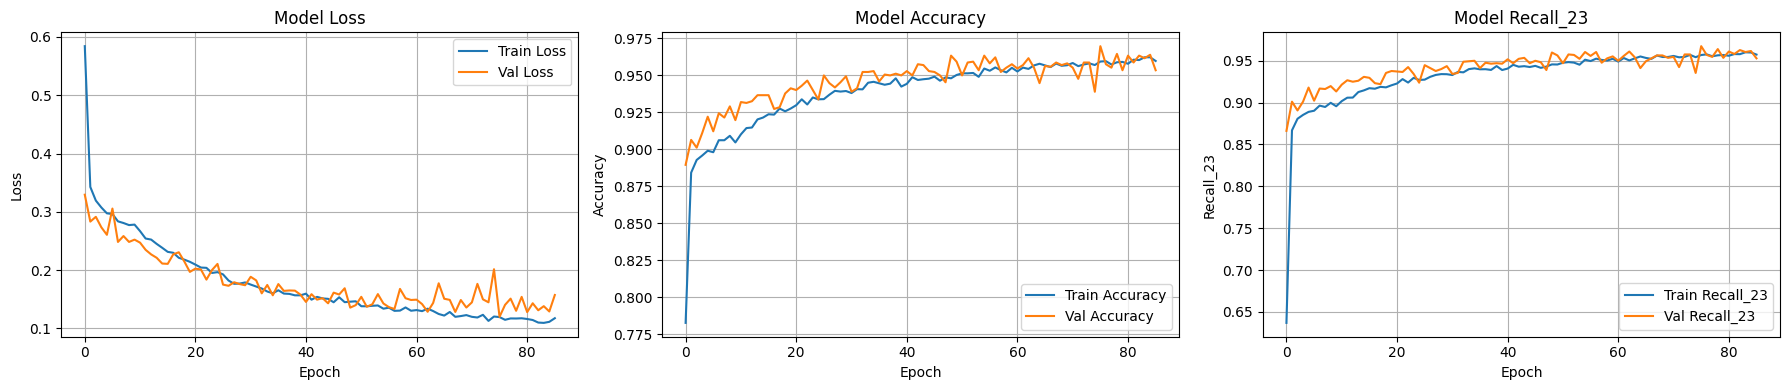

Validation Loss = 0.1197

[24/72] Testing: Nodes=32 | Dropout=0 | LR=0.005 | Batch=64
   -> Final Train Loss: 0.1521, Acc: 0.9476
   -> Final Val Loss:   0.1652, Acc: 0.9523


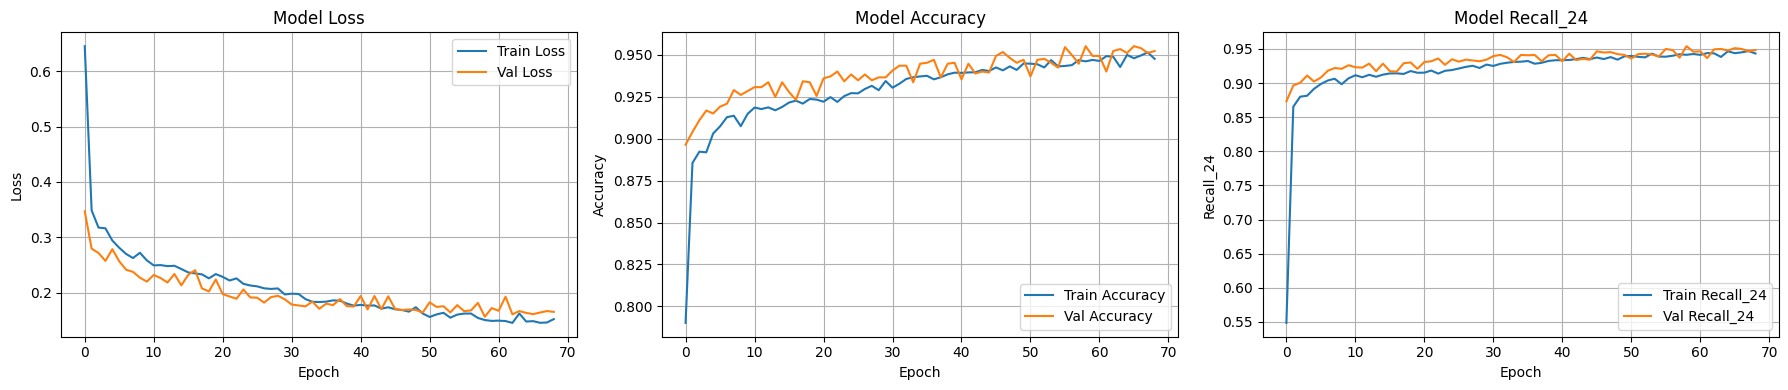

Validation Loss = 0.1564

[25/72] Testing: Nodes=32 | Dropout=0 | LR=0.001 | Batch=16
   -> Final Train Loss: 0.1486, Acc: 0.9473
   -> Final Val Loss:   0.1491, Acc: 0.9529


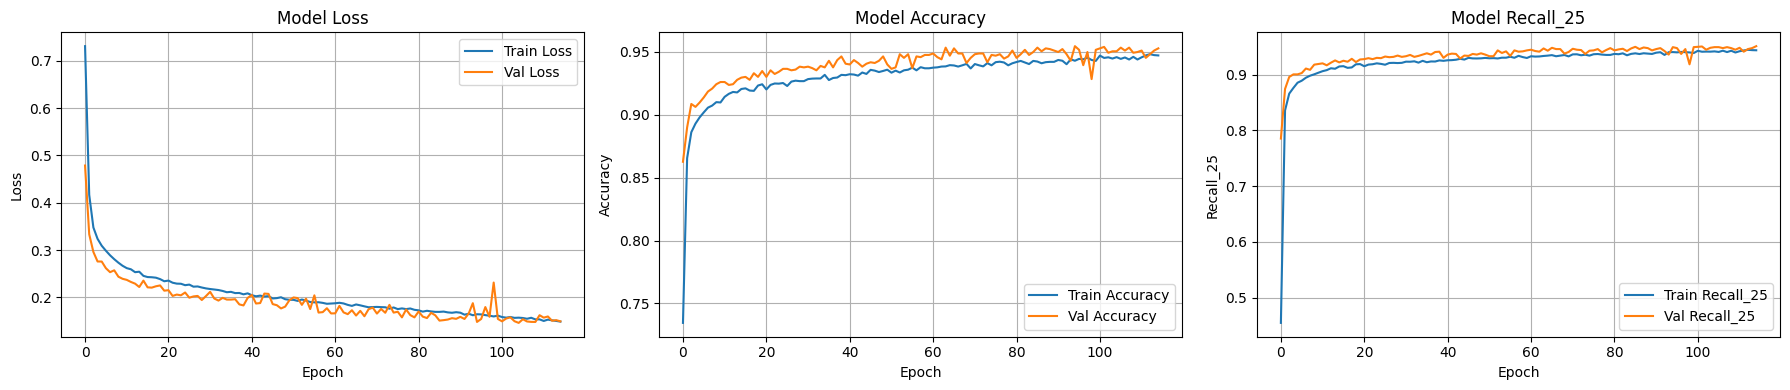

Validation Loss = 0.1459

[26/72] Testing: Nodes=32 | Dropout=0 | LR=0.001 | Batch=32
   -> Final Train Loss: 0.1877, Acc: 0.9339
   -> Final Val Loss:   0.1902, Acc: 0.9465


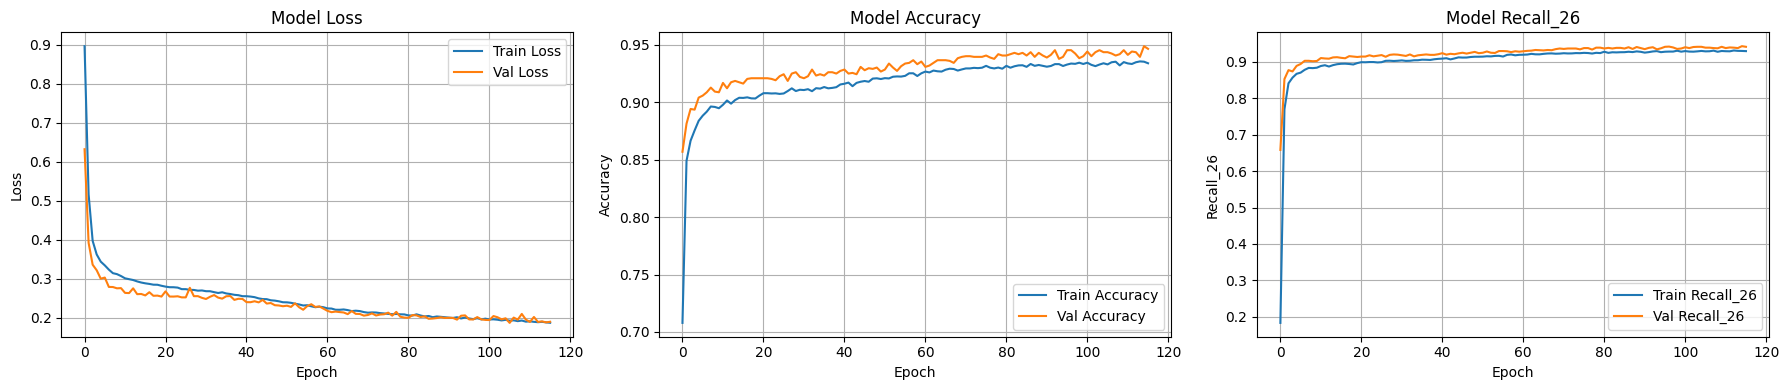

Validation Loss = 0.1874

[27/72] Testing: Nodes=32 | Dropout=0 | LR=0.001 | Batch=64
   -> Final Train Loss: 0.1852, Acc: 0.9369
   -> Final Val Loss:   0.1862, Acc: 0.9383


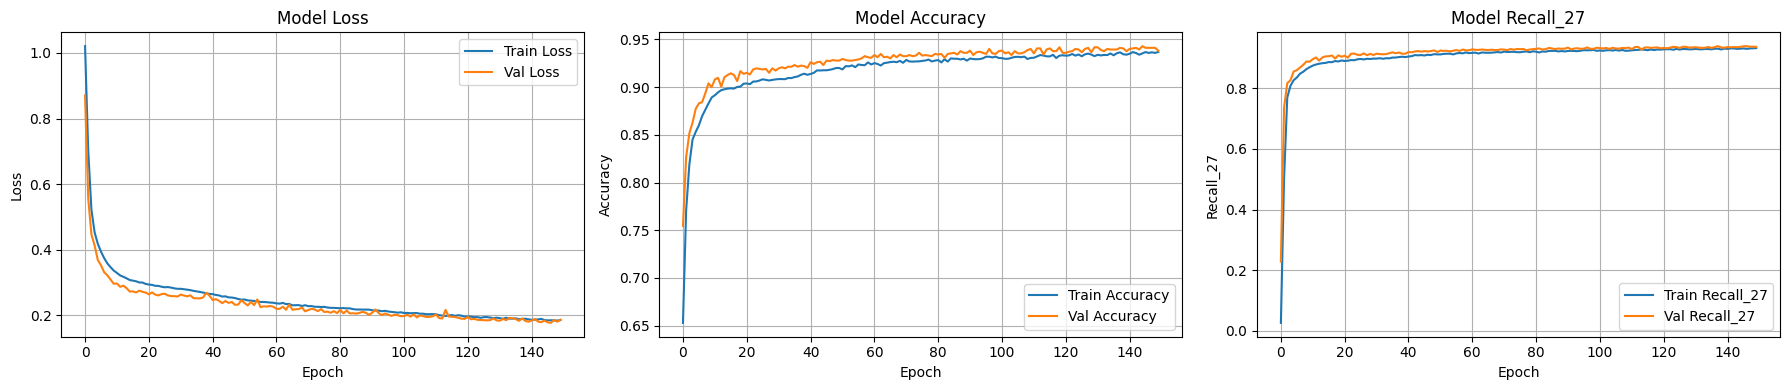

Validation Loss = 0.1862

[28/72] Testing: Nodes=32 | Dropout=0.2 | LR=0.01 | Batch=16
   -> Final Train Loss: 0.2836, Acc: 0.9051
   -> Final Val Loss:   0.2153, Acc: 0.9232


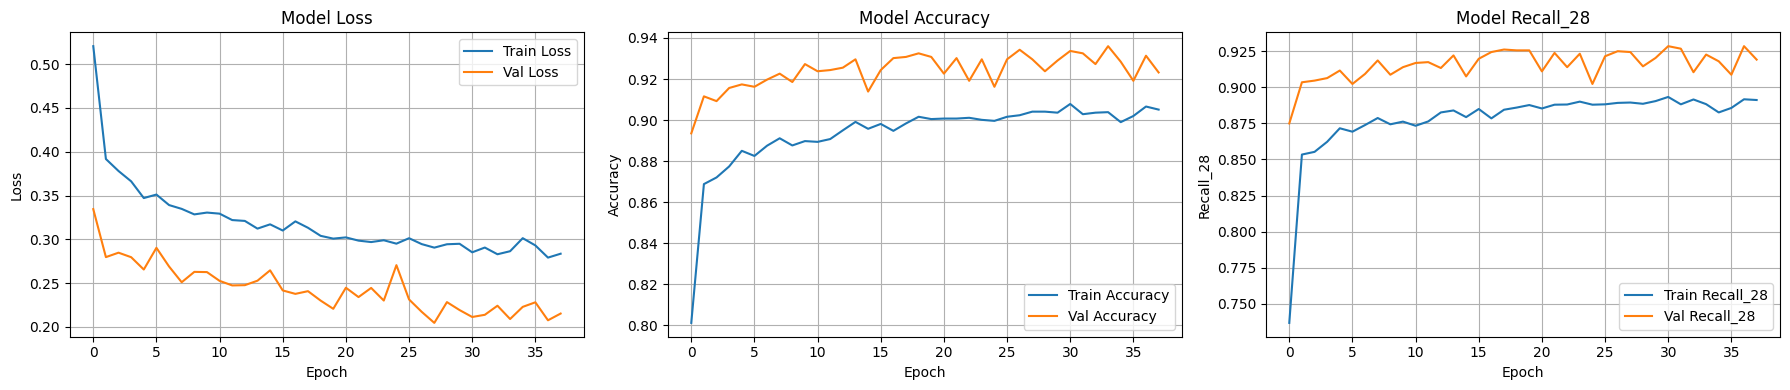

Validation Loss = 0.2046

[29/72] Testing: Nodes=32 | Dropout=0.2 | LR=0.01 | Batch=32
   -> Final Train Loss: 0.2503, Acc: 0.9185
   -> Final Val Loss:   0.1910, Acc: 0.9348


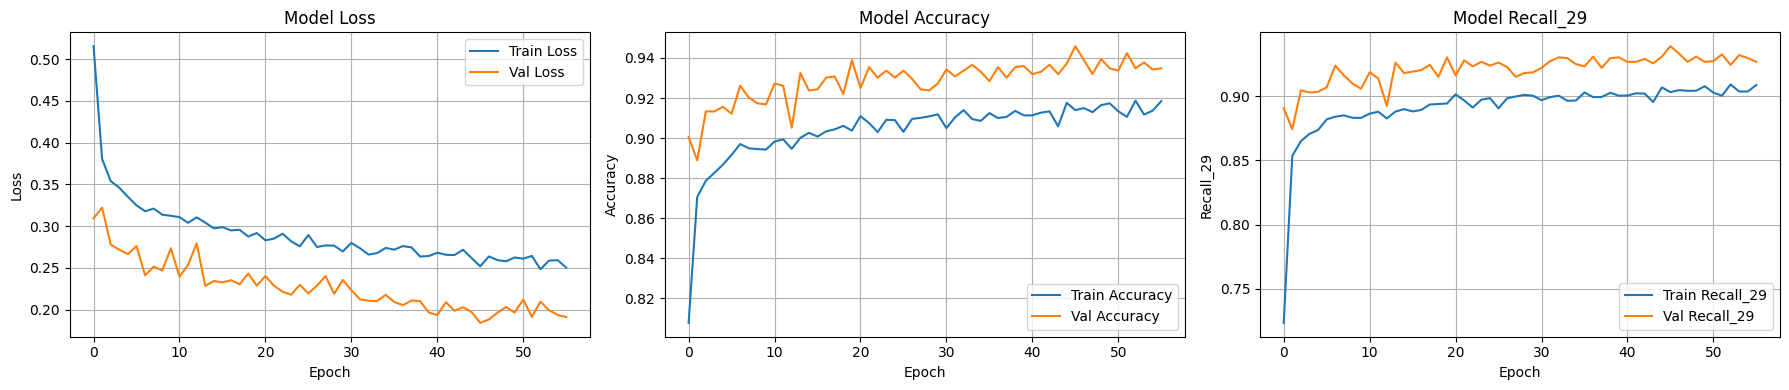

Validation Loss = 0.1840

[30/72] Testing: Nodes=32 | Dropout=0.2 | LR=0.01 | Batch=64


KeyboardInterrupt: 

In [21]:
least_val_loss = float('inf')
least_loss_model = None
best_nn_model_config = None
epochs = 150  # Set max epochs

# Search Grid
node_counts = [16, 32, 64, 128]
dropout_probs = [0, 0.2]
learning_rates = [0.01, 0.005, 0.001]
batch_sizes = [16, 32, 64]

total_runs = len(node_counts) * len(dropout_probs) * len(learning_rates) * len(batch_sizes)
current_run = 0

print(f"Starting Grid Search on {total_runs} combinations...")

for num_nodes in node_counts:
    for dropout_prob in dropout_probs:
        for lr in learning_rates:
            for batch_size in batch_sizes:
                current_run += 1
                print(f"\n[{current_run}/{total_runs}] Testing: Nodes={num_nodes} | Dropout={dropout_prob} | LR={lr} | Batch={batch_size}")
                
                # Call the train function
                model, history = train_model(
                    X_train, y_train,
                    X_val, y_val,
                    num_nodes, dropout_prob, lr, batch_size, epochs
                )

                # Optional: Plot history for every single model (can get spammy, maybe only plot best?)
                plot_history(history) 
                # Evaluate
                val_loss = model.evaluate(X_val, y_val, verbose=0)[0]
                print(f"Validation Loss = {val_loss:.4f}")

                if val_loss < least_val_loss:
                    least_val_loss = val_loss
                    least_loss_model = model
                    print(f"least val_loss = {least_val_loss:.4f}")
                    
                    best_nn_model_config = {
                        'num_nodes': num_nodes,
                        'dropout_prob': dropout_prob,
                        'learning_rate': lr,
                        'batch_size': batch_size,
                        'epochs': len(history.history['loss']), # Actual epochs run
                        'val_loss': round(val_loss, 5)
                    }
                       
                    print(f"   *** NEW BEST MODEL FOUND *** (Val Loss: {least_val_loss:.4f})")
                    # Plot the history only for new best models to save space65
                    plot_history(history)

print("\nHyperparameter tuning complete.")
print(f"Best Configuration: {best_nn_model_config}")

EVALUATE AND SAVE MODEL

In [ ]:
# 1. Evaluate on Test Set
print("\n--- Final Test Evaluation ---")
loss, acc, recall = least_loss_model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {acc:.4f}")
print(f"Test Recall:   {recall:.4f}")

# 2. Detailed Report
y_pred_probs = least_loss_model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

class_names = ['Awake (0)', 'Sleep (1)', 'Yawning (2)']
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

# 3. Confusion Matrix
plt.figure(figsize=(6, 5))
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.show()

# 4. Save Model
least_loss_model.save("./model/best_drowsiness_model.keras")

with open("./model/best_drowsiness_model_config.json", "w") as f:
    json.dump(best_nn_model_config, f, indent = 4)

Model input shape: (None, 30, 9)
Model output shape: (None, 4)

Model layers:
0 Conv1D None None
1 MaxPooling1D None None
2 LSTM None None
3 Dropout None None
4 Dense None None
5 Dropout None None
6 Dense None None

Dataset feature shapes:
X shape: (2055, 10)
X columns (first 50): ['EAR', 'MAR', 'PITCH', 'YAW', 'ROLL', 'D_SLUMP', 'R_TILT', 'EYE_CL', 'FACIAL_DISPLAYED', 'POSE_DISPLAYED']
X_train shape: (1438, 10)
X_val shape: (308, 10)
X_test shape: (309, 10)
n_feature variable: 10

df columns (first 50): ['EAR', 'MAR', 'PITCH', 'YAW', 'ROLL', 'D_SLUMP', 'R_TILT', 'EYE_CL', 'FACIAL_DISPLAYED', 'POSE_DISPLAYED', 'LABEL', 'Image_Path']


,EAR,MAR,PITCH,YAW,ROLL,D_SLUMP,R_TILT,EYE_CL,FACIAL_DISPLAYED,POSE_DISPLAYED,LABEL,Image_Path
0,0.3331,0.5861,31.6382,-5.2346,-5.0504,1.0640,0.5070,0.0621,1,1,0,c:\VGU_projects\Drowsiness_detector\AI_Drowsin...
1,0.2696,0.2103,23.0431,-1.6258,-0.4376,0.9222,-1.8882,0.0536,1,1,0,c:\VGU_projects\Drowsiness_detector\AI_Drowsin...
2,0.4142,0.2831,145.9168,0.9384,-1.5578,0.7423,-1.2571,0.0878,1,1,0,c:\VGU_projects\Drowsiness_detector\AI_Drowsin...
3,0.4271,0.2635,32.7882,-25.6324,3.5415,1.0925,4.0142,0.0811,1,1,0,c:\VGU_projects\Drowsiness_detector\AI_Drowsin...
4,0.3590,0.2906,57.2217,-1.0224,-0.2451,0.9877,0.7673,0.0683,1,1,0,c:\VGU_projects\Drowsiness_detector\AI_Drowsin...


In [ ]:
model_path = './Outputs/drowsiness_model.h5'
if os.path.exists(model_path):
    least_loss_model = tf.keras.models.load_model(model_path)
    print(f"Loaded model from {model_path}")
    least_loss_model.summary()
else:
    raise FileNotFoundError(f"Model file not found: {model_path}")

Loaded model from ./Outputs/drowsiness_model.h5


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 28, 64)         │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 14, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 128)            │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 109,126 (426.28 KB)

 Trainable params: 109,124 (426.27 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

In [ ]:
# 4. Generate and Plot Confusion Matrix
cm = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, 
            yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

array([[0.29816107, 0.81582663, 0.0944036 , ..., 0.5022779 , 1.        ,
        1.        ],
       [0.38528852, 0.17363676, 0.24741036, ..., 0.70501139, 1.        ,
        1.        ],
       [0.08192771, 0.20573539, 0.24252442, ..., 0.15489749, 1.        ,
        1.        ],
       ...,
       [0.36613824, 0.20774495, 0.22801902, ..., 0.65375854, 1.        ,
        1.        ],
       [0.10615092, 0.1729307 , 0.30824751, ..., 0.18906606, 1.        ,
        1.        ],
       [0.51528218, 0.2648816 , 0.17039719, ..., 0.63439636, 1.        ,
        1.        ]], shape=(309, 10))

In [ ]:
# 5. Extract Specific Metrics (Optional, for logging)
accuracy = accuracy_score(y_true, y_pred_classes)
# 'weighted' average accounts for class imbalance
precision = precision_score(y_true, y_pred_classes, average='weighted')
recall = recall_score(y_true, y_pred_classes, average='weighted')
f1 = f1_score(y_true, y_pred_classes, average='weighted')

print(f"\nOverall Accuracy:  {accuracy:.4f}")
print(f"Weighted Precision: {precision:.4f}")
print(f"Weighted Recall:    {recall:.4f}")
print(f"Weighted F1-Score:  {f1:.4f}")

ValueError: Exception encountered when calling Sequential.call().

[1mInvalid input shape for input Tensor("data:0", shape=(32, 10), dtype=float32). Expected shape (None, 30, 9), but input has incompatible shape (32, 10)[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(32, 10), dtype=float32)
  • training=False
  • mask=None
  • kwargs=<class 'inspect._empty'>

Model expects sequences: seq_len=30, feat_count=9
Data has 10 features; keeping first 9 columns: ['EAR', 'MAR', 'PITCH', 'YAW', 'ROLL', 'D_SLUMP', 'R_TILT', 'EYE_CL', 'FACIAL_DISPLAYED']
Created 280 sequences with shape (280, 30, 9)
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Sequence Test Accuracy: 0.0571 (5.71%) on 280 sequences

Classification report (sequences):
              precision    recall  f1-score   support

           0     0.0571    1.0000    0.1081        16
           1     0.0000    0.0000    0.0000        21
           2     0.0000    0.0000    0.0000       243

    accuracy                         0.0571       280
   macro avg     0.0190    0.3333    0.0360       280
weighted avg     0.0033    0.0571    0.0062       280

Saved sequence-level predictions to ./Outputs/test_predictions_sequences.csv


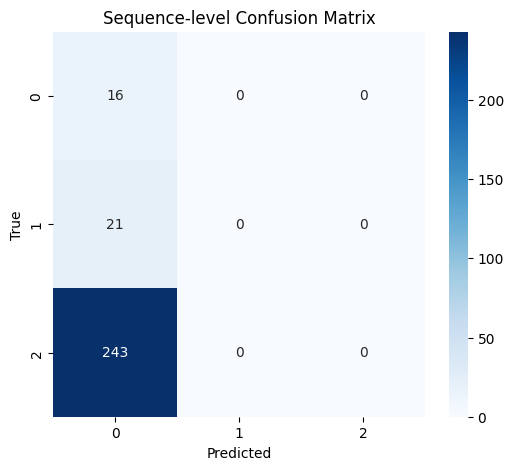

Number of misclassified sequences: 264 / 280


,start_idx,true,pred,pred_prob_max,prob_0,prob_1,prob_2,prob_3
0,0,2,0,0.999997,0.999997,0.000003,8.882482e-11,1.734185e-08
1,1,2,0,0.999998,0.999998,0.000002,3.428323e-11,4.419793e-09
2,2,2,0,0.999998,0.999998,0.000002,4.991147e-11,8.504173e-09
3,3,2,0,0.999998,0.999998,0.000002,3.192625e-11,4.974457e-09
4,4,2,0,0.999998,0.999998,0.000002,5.055764e-11,1.177840e-08
5,5,2,0,0.999998,0.999998,0.000002,3.133072e-11,6.513967e-09
6,6,2,0,0.999999,0.999999,0.000001,3.048458e-11,9.867508e-09
7,7,2,0,0.999999,0.999999,0.000001,2.298562e-11,7.347667e-09
8,8,2,0,0.999999,0.999999,0.000001,2.432113e-11,6.740412e-09
9,9,2,0,0.999999,0.999999,0.000001,2.187580e-11,7.329750e-09


In [ ]:
# Check the counts of your final processed dataframe (before splitting)
# Assuming your target column is 'LABEL'
class_counts = df_clean['LABEL'].value_counts().sort_index()
print(class_counts)

plt.figure(figsize=(8,5))
sns.barplot(x=class_counts.index, y=class_counts.values, palette='viridis')
plt.title('Class Distribution')
plt.xlabel('Label (0=Awake, 1=Drowsy, etc.)')
plt.ylabel('Number of Samples')
plt.show()

In [ ]:
least_loss_model.save("./model/best_drowsiness_model.keras")

with open("./model/best_drowsiness_model_config.json", "w") as f:
    json.dump(best_nn_model_config, f, indent = 4)

KeyError: 'Image_Path'

In [ ]:
model_path = './model/best_drowsiness_model.keras'
if os.path.exists(model_path):
    least_loss_model = tf.keras.models.load_model(model_path)
    print(f"Loaded model from {model_path}")
    least_loss_model.summary()
else:
    raise FileNotFoundError(f"Model file not found: {model_path}")

with open('./model/best_drowsiness_model_config.json', 'r') as f:
    cfg = json.load(f)

print(cfg)

In [ ]:
# Inspect saved model and dataset shapes to plan reshaping
print('Model input shape:', getattr(least_loss_model, 'input_shape', 'N/A'))
print('Model output shape:', getattr(least_loss_model, 'output_shape', 'N/A'))
print('\nModel layers:')
for i, layer in enumerate(least_loss_model.layers):
    print(i, layer.__class__.__name__, getattr(layer, 'input_shape', None), getattr(layer, 'output_shape', None))

print('\nDataset feature shapes:')
try:
    print('X shape:', X.shape)
    print('X columns (first 50):', list(X.columns)[:50])
except Exception as e:
    print('Could not show X columns:', e)

print('X_train shape:', X_train.shape)
print('X_val shape:', X_val.shape)
print('X_test shape:', X_test.shape)
print('n_feature variable:', n_feature)

# Show a few rows of the raw dataframe to look for grouping identifiers (video, timestamp, subject)
print('\ndf columns (first 50):', list(df.columns)[:50])
display(df.head())

In [ ]:
mylist = [1, 2, 1, 2, 1, 2, 1, 2, 1, 2]
pred_list = np.array(mylist)

pred_list_shaped = pred_list.reshape(1, 10) 

print(pred_list_shaped.shape)

In [ ]:
y_testing = least_loss_model.predict(pred_list_shaped)

y_testing_classes = np.argmax(y_testing, axis=1)

y_testing_classes

label_name = y_testing_classes

print(label_name)